Example script to run Illustris, from https://www.tng-project.org/data/docs/scripts/.
Except for this first cell, all markdown text is copied or paraphrased from the example script itself, while inline comments are things I've added myself.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import numpy as np 
import matplotlib as mpl
import os
import sys
import illustris_python as il
import matplotlib.pyplot as plt

### ongoing questions...

- what is a "snapshot"? $\rightarrow$ a snaphot in time! redshift
- what's up with "stellar half mass radius"?
- what is a "Subfind" subhalo?

### Group Catalogs

$\Rightarrow$ Walking through the process of downloading and exploring data in the Subfind group catalogs.

Define the base path for the data:

In [3]:
basePath = '/scratch/08811/aew492/Illustris-3/output'

Load the total masses (SubhaloMass) and star formation rate within twice the stellar half mass radius (SubhaloSFRinRad) of all the Subfind subhalos:

In [4]:
# specifying which fields we want to load:
    # 'SubhaloMass' = total mass
    # 'SubhaloSFRinRad' = star formation rate within twice the stellar half mass radius
fields = ['SubhaloMass', 'SubhaloSFRinRad']
# what is a "Subfind" subhalo?

In [5]:
# path to the downloaded catalog
fn = os.path.join(basePath, 'groups_135/groups_135.1.hdf5')

In [6]:
# load in the desired subhalos
subhalos = il.groupcat.loadSubhalos(basePath, 135, fields=fields)
# 135 specifies the snapshot: corresponds to a redshift

Let's look at the return:
It's a dict/hash/struct with a key `count` indicating the number of subhalos.
Each requested field is returned as a numeric array with a key name equal to its field name in the group catalog.

In [7]:
subhalos.keys()

dict_keys(['count', 'SubhaloMass', 'SubhaloSFRinRad'])

In [8]:
# the number of subhalos in this catalog
subhalos['SubhaloMass'].shape

(121209,)

Make a simple scatter plot of the relation (note the units):

In [9]:
mass_msun = subhalos['SubhaloMass'] * 1e10 / 0.704 # I guess this is a unit conversion,
                                                        # but what are the specific values?

Text(0, 0.5, 'Star Formation Rate [$M_\\odot / yr$]')

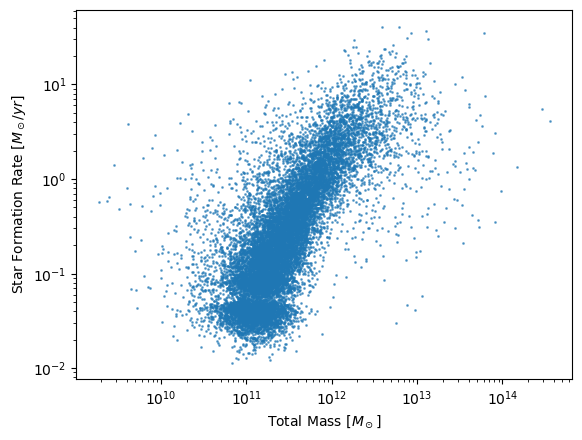

In [10]:
# I've adjusted minor plot params but otherwise this is the same as in the original example
fig, ax = plt.subplots()

ax.plot(mass_msun, subhalos['SubhaloSFRinRad'], marker='.', ms=2, ls='None', alpha=0.6)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Total Mass [$M_\odot$]')
ax.set_ylabel('Star Formation Rate [$M_\odot / yr$]')

Let's get a list of primary subhalo IDs by loading the `GroupFirstSub` field from the FoF groups.

In [11]:
# loadHalos: Load all halo information from the entire group catalog for one snapshot
#        (optionally restrict to a subset given by fields).
# FoF = friends-of-friends (standard algorithm used to generate the Group fields)
GroupFirstSub = il.groupcat.loadHalos(basePath, 135, fields=['GroupFirstSub'])

In [12]:
GroupFirstSub.dtype

dtype('uint32')

In [13]:
GroupFirstSub.shape

(131727,)

For the 5 most massive central subhalos, let's load all their fields from the group catalog and print a gas fraction (gas mass over total baryonic mass) in the stellar half mass radius.

In [14]:
# partTypeNum: Mapping between common names and numeric particle types.
ptNumGas = il.snapshot.partTypeNum('gas')
ptNumGas

0

In [15]:
ptNumStars = il.snapshot.partTypeNum('stars')
ptNumStars

4

In [16]:
# loadSingle: Return complete group catalog information for one halo or subhalo.
for i in range(5):
    all_fields = il.groupcat.loadSingle(basePath, 135, subhaloID=GroupFirstSub[i])
    gas_mass = all_fields['SubhaloMassInHalfRadType'][ptNumGas] # total mass of gas in this halo
    stars_mass = all_fields['SubhaloMassInHalfRadType'][ptNumStars] # total mass of stars in this halo
    frac = gas_mass / (gas_mass + stars_mass)  # so this is the fraction of gas mass to total baryonic mass
                                                    # in the "stellar half mass radius"
    print(f"subhalo ID = {GroupFirstSub[i]}; gas makes up {frac*100:.1f}% of total baryonic mass")

subhalo ID = 0; gas makes up 6.9% of total baryonic mass
subhalo ID = 608; gas makes up 2.4% of total baryonic mass
subhalo ID = 1030; gas makes up 6.4% of total baryonic mass
subhalo ID = 1396; gas makes up 0.4% of total baryonic mass
subhalo ID = 1801; gas makes up 12.2% of total baryonic mass


### Snapshot Data

I've downloaded the full `z=0` snapshot to play with (20 GB).

First, load the `Masses` of all the gas cells in the entire box, and calculate their mean, converting to log solar masses.

In [17]:
fields = ['Masses'] # which fields we want to load
gas_mass = il.snapshot.loadSubset(basePath, 135, 'gas', fields=fields)
print(np.log10(np.mean(gas_mass, dtype='double') * 1e10/0.704))  # last term converts to solar masses

7.921601619405842


In [18]:
gas_mass.shape

(87571556,)

Next, load the spatial `Coordinates` of all the dark matter particles in the box, and make a quick image with a 2D histogram, projecting out the z-axis.

Text(0.5, 1.0, 'DARK MATTER PIXELS !!!!!!!!!!!!!!!!!')

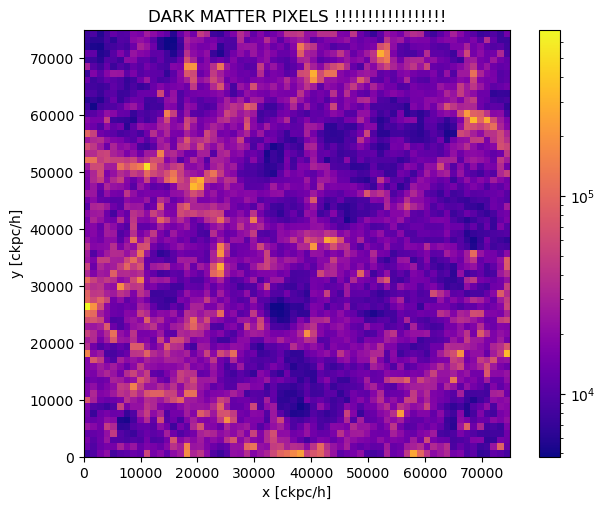

In [19]:
dm_pos = il.snapshot.loadSubset(basePath, 135, 'dm', ['Coordinates'])
fig, ax = plt.subplots(figsize=(6.5,5))
_, _, _, im = ax.hist2d(dm_pos[:,0], dm_pos[:,1], cmap='plasma', norm=mpl.colors.LogNorm(), bins=64)
ax.set_xlim([0,75000])
ax.set_ylim([0,75000])
ax.set_aspect('equal')
ax.set_xlabel('x [ckpc/h]')
ax.set_ylabel('y [ckpc/h]')
fig.colorbar(im, ax=ax)
fig.tight_layout()
ax.set_title('DARK MATTER PIXELS !!!!!!!!!!!!!!!!!')

Finally, load the star particles belonging to FoF halo ID 100 (all fields). Print the minimum and maximum of all positions for each axis to check we have loaded only stars in a localized region.

In [20]:
stars = il.snapshot.loadHalo(basePath, 135, 100, 'stars')
stars.keys()

dict_keys(['count', 'Coordinates', 'GFM_InitialMass', 'GFM_Metallicity', 'GFM_Metals', 'GFM_StellarFormationTime', 'GFM_StellarPhotometrics', 'Masses', 'NumTracers', 'ParticleIDs', 'Potential', 'StellarHsml', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities'])

In [21]:
for i in range(3):
    print(np.min(stars['Coordinates'][:,i]), np.max(stars['Coordinates'][:,i]))

17993.686 19585.623
58372.957 59606.2
67596.48 68610.61


In [25]:
stars['count']

5548